### Importing Necessary Modules and Libraries

In [194]:
import gym 
import random
import subprocess
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import clear_output

### Taxi v3 Open AI Gym Environment

In [195]:
env = gym.make("Taxi-v3", new_step_api=True)
env.reset()

print("########## Taxi-Domain Environment ##########", end="\n\n")
print(f"Observation Space: {env.observation_space}")
print(f"Observation Space Shape: {env.observation_space.n}")
print(f"Action Space: {env.action_space}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Reward Threshold: {env.spec.reward_threshold}")

########## Taxi-Domain Environment ##########

Observation Space: Discrete(500)
Observation Space Shape: 500
Action Space: Discrete(6)
Number of Actions: 6
Reward Threshold: 8


### Random Action, Transition Probability

In [196]:
random_action = random.randint(0, env.action_space.n)
next_state, reward, terminal, info, prob = env.step(random_action)
print(f"Action Taken: {random_action}")
print(f"Transition Probability: {prob}")
print(f"Next State: {next_state}")
print(f"Reward: {reward}")
print(f"Terminal: {terminal}")

Action Taken: 2
Transition Probability: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
Next State: 291
Reward: -1
Terminal: False


### Epsilon Greedy

In [197]:
def epsilon_greedy(q_value, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.randint(q_value.shape[-1])
    else:
        return np.argmax(q_value[state])

### Goal State (R,G,Y,B)

In [198]:
goal = {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

### Hardcoded Options (For Comparison)

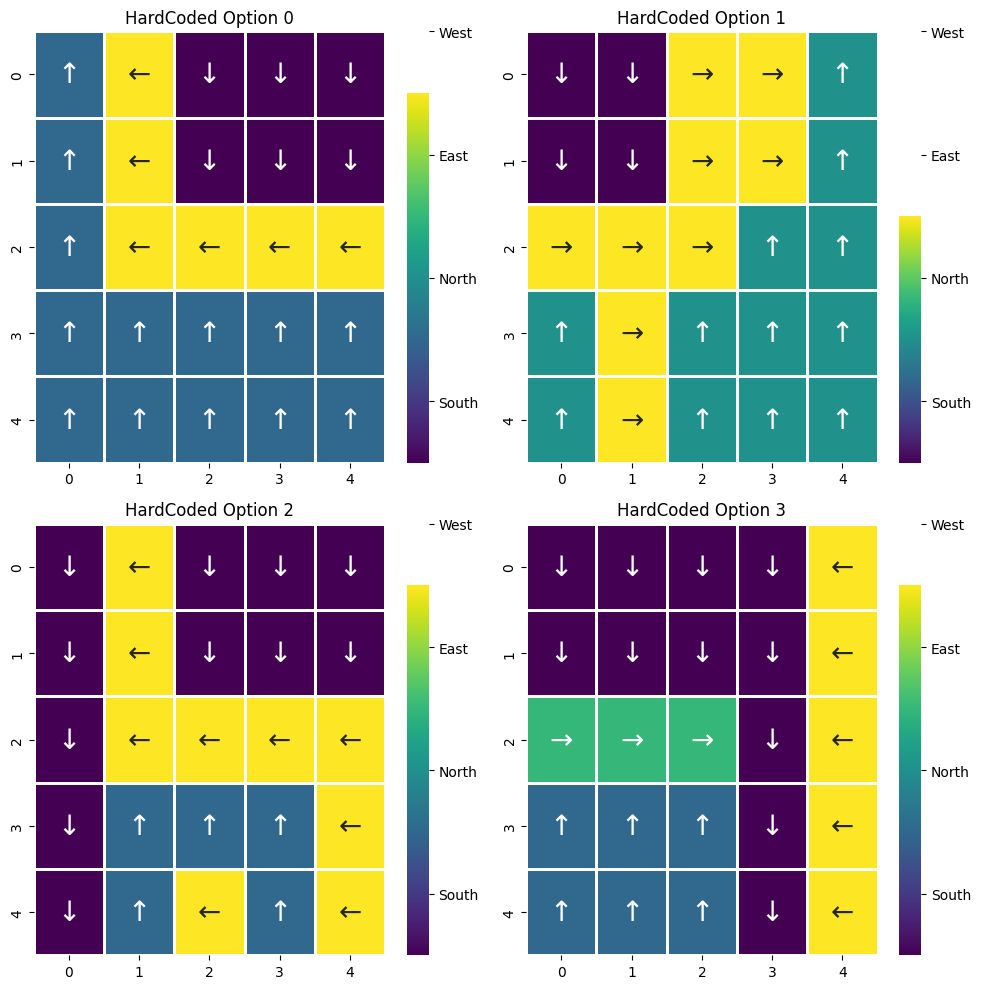

In [199]:
OptionR = np.array([[1,3,0,0,0],
                    [1,3,0,0,0],
                    [1,3,3,3,3],
                    [1,1,1,1,1],
                    [1,1,1,1,1]])

OptionG = np.array([[0,0,2,2,1],
                    [0,0,2,2,1],
                    [2,2,2,1,1],
                    [1,2,1,1,1],
                    [1,2,1,1,1]])

OptionY = np.array([[0,3,0,0,0],
                    [0,3,0,0,0],
                    [0,3,3,3,3],
                    [0,1,1,1,3],
                    [0,1,3,1,3]])

OptionB = np.array([[0,0,0,0,3],
                    [0,0,0,0,3],
                    [2,2,2,0,3],
                    [1,1,1,0,3],
                    [1,1,1,0,3]])

Options = [OptionR, OptionG, OptionY, OptionB]

fig, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    for j in range(2):
        labels = {0:'\u2193', 
                  1:'\u2191', 
                  2:'\u2192', 
                  3:'\u2190'}
        annot_text = np.vectorize(labels.get)((Options[2*i+j]))
        ax = sns.heatmap((Options[2*i+j]), ax=axis[i,j],annot=annot_text,fmt="",linewidths=1,linecolor='white',cmap='viridis',annot_kws={"size":20})
        axis[i,j].set_title(f"HardCoded Option {i*2+j}")
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i + 0.5 for i in range(4)])
        c_bar.set_ticklabels(['South', 'North', 'East', 'West'])

plt.tight_layout()
plt.show()

Now the new action space will contain

Primitive Actions: [South, North, East, West, Pick, Drop]

Options: [OptionR, OptionG, OptionY, OptionB]

Total Actions :[South, North, East, West, Pick, Drop, OptionR, OptionG, OptionY, OptionB]

Corresponding to [0,1,2,3,4,5,6,7,8,9]

### Option Selection and Goal State

In [200]:
def Option(env, state, q_value, goalNum, epsilon):

    optdone = False
    x, y, pas, drop = list(env.decode(state))

    if (x == goal[goalNum][0] and y == goal[goalNum][1]):

        optdone = True

        if pas == goalNum:
            optact = 4
        elif drop == goalNum:
            optact = 5
        else:
            optact = np.random.randint(0, 4)
    
    else:
        optact = epsilon_greedy(q_value[goalNum], 5*x+y, epsilon)
    
    return [optact, optdone]

In [201]:
def Sub(state):
    _, _, pas, drop = env.decode(state)
    return 4*pas+drop

### Intra Option Q Learning for Options

In [202]:
num_options = 4
episodes = 1000
q_intra_reward = []

gamma = 0.9
alpha = 0.1
epsilon = 0.1

q_values_option = np.zeros((20, num_options))
state_count_option = np.zeros((20, num_options))
q_values_primitive = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_options)}
state_count = {i:np.zeros(env.observation_space.n//20) for i in range(num_options)}

eps = {i:0.01 for i in range(num_options)}
eps_min = 0.01
eps_decay = 0.99
eps_start = 0.1

for _ in tqdm(range(episodes)):

    state = env.reset()
    done = False
    total_reward = 0

    while not done:

        _, _, pas, drop = list(env.decode(state))
        subState = 4*pas + drop
        action = epsilon_greedy(q_values_option, subState, eps_start)
        eps_start = max(eps_min, eps_decay*eps_start)

        option = action
        optdone = False
        prev = state

        while not optdone and not done:

            optact, optdone = Option(env, state, q_values_primitive, option, eps[option])
            next_state, reward, done, _, _ = env.step(optact)
            total_reward+=reward

            x, y, pas, drop = list(env.decode(state))
            x1, y1, pas1, drop1 = list(env.decode(next_state))

            reward_temp = reward
            if optdone:
                reward_temp = 20
            if optact < 4:
                q_values_primitive[option][5*x+y, optact] = (1-alpha)*q_values_primitive[option][5*x+y, optact] + alpha*(reward_temp+gamma*np.max(q_values_primitive[option][5*x1+y1, :])) 
                state_count[option][5*x+y] += 1

            for i in range(num_options):
                temp_optact, temp_optdone = Option(env, state, q_values_primitive, i, epsilon)

                if temp_optact == optact:
                    u = (1-temp_optdone)*q_values_option[Sub(next_state), i] + (temp_optdone)*np.max(q_values_option[Sub(next_state), :])
                    q_values_option[Sub(state), i] = (1-alpha)*q_values_option[Sub(state), i] + alpha*(reward+gamma*u)
                    state_count_option[Sub(state), i]+=1
            state = next_state
    
    q_intra_reward.append(total_reward)

100%|██████████| 1000/1000 [00:02<00:00, 451.67it/s]


In [203]:
state_count_option
# q_values_option.shape

array([[   0.,    0.,    0.,    0.],
       [ 446.,   86.,  229.,   87.],
       [ 461.,   93.,  208.,   82.],
       [ 467.,  133.,  282.,  156.],
       [ 100.,  508.,  130.,  192.],
       [   0.,    0.,    0.,    0.],
       [  65.,  437.,   51.,  152.],
       [  51.,  430.,   61.,  132.],
       [ 254.,   75.,  559.,   75.],
       [ 278.,  122.,  498.,  149.],
       [   0.,    0.,    0.,    0.],
       [ 243.,   76.,  467.,   61.],
       [  89.,  115.,   87.,  436.],
       [ 493.,  413.,  366.,  750.],
       [ 441.,  445.,  396.,  763.],
       [   0.,    0.,    0.,    0.],
       [1868.,  458.,  793.,  465.],
       [ 473., 1760.,  484.,  722.],
       [ 818.,  438., 1767.,  253.],
       [ 446.,  634.,  354., 1714.]])

The Mean Reward with this Option is: 6.61


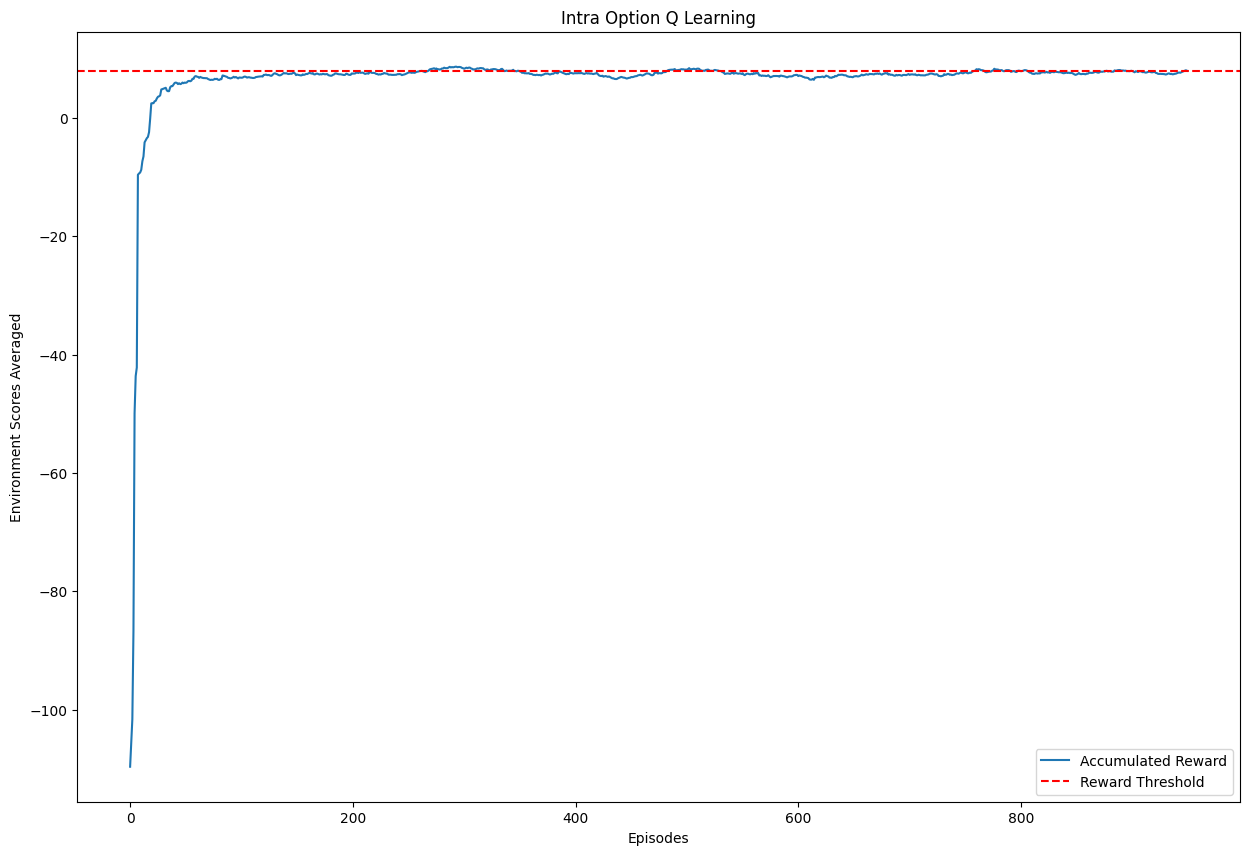

In [204]:
average_reward = [np.average(q_intra_reward[i:i+50]) for i in range(len(q_intra_reward) - 50)]
plt.figure(figsize=(15, 10))
plt.plot(average_reward, label='Accumulated Reward')
plt.xlabel('Episodes')
plt.ylabel('Environment Scores Averaged')
plt.title("Intra Option Q Learning")
plt.axhline(y=env.spec.reward_threshold, color="red", linestyle='--', label="Reward Threshold")
plt.legend()

print(f"The Mean Reward with this Option is: {round(np.mean(average_reward),2)}")

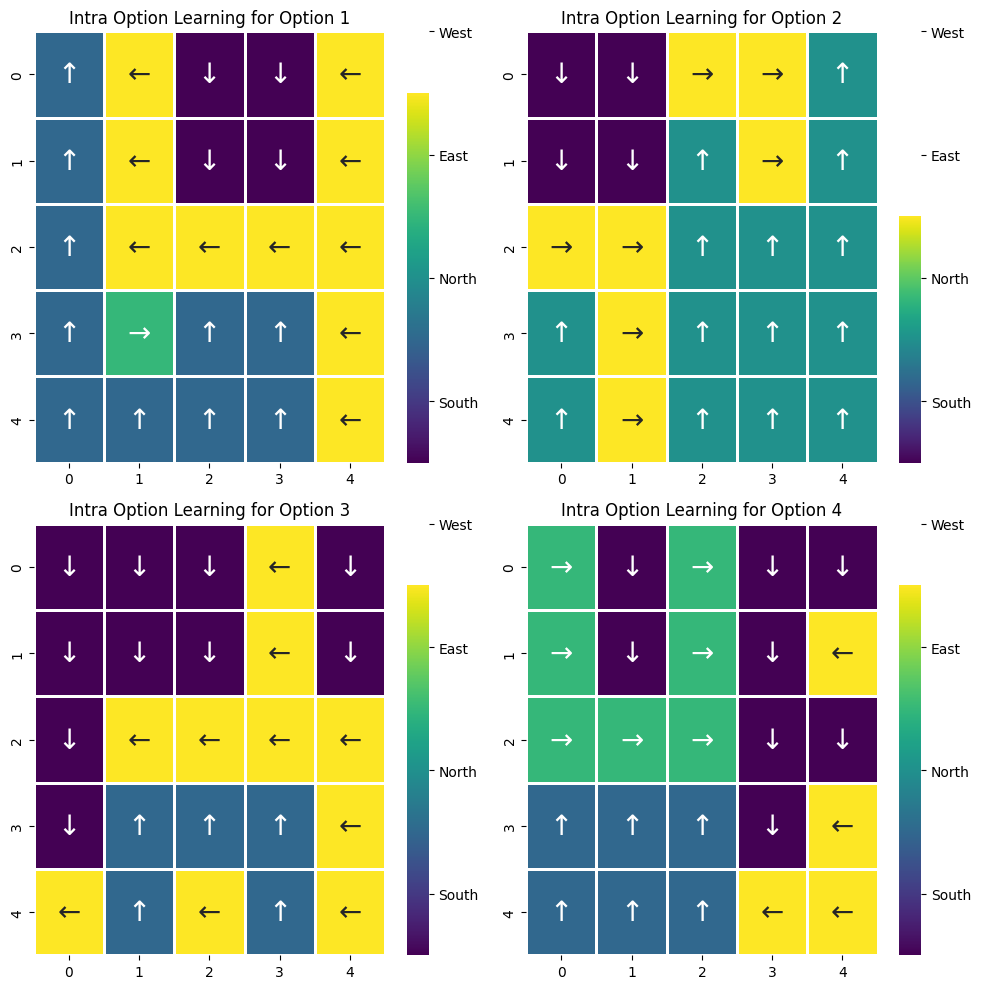

In [205]:
fig, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    for j in range(2):
        labels = {0:'\u2193', 
                  1:'\u2191', 
                  2:'\u2192', 
                  3:'\u2190'}
        annot_text = np.vectorize(labels.get)(np.argmax(q_values_primitive[2*i+j], axis=1).reshape(5,5))
        ax = sns.heatmap(np.argmax(q_values_primitive[2*i+j], axis=1).reshape(5,5), ax=axis[i,j],annot=annot_text,fmt="",linewidths=1,linecolor='white',cmap='viridis',annot_kws={"size":20})
        axis[i,j].set_title(f"Intra Option Learning for Option {i*2+j+1}")
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i + 0.5 for i in range(4)])
        c_bar.set_ticklabels(['South', 'North', 'East', 'West'])

plt.tight_layout()
plt.show()

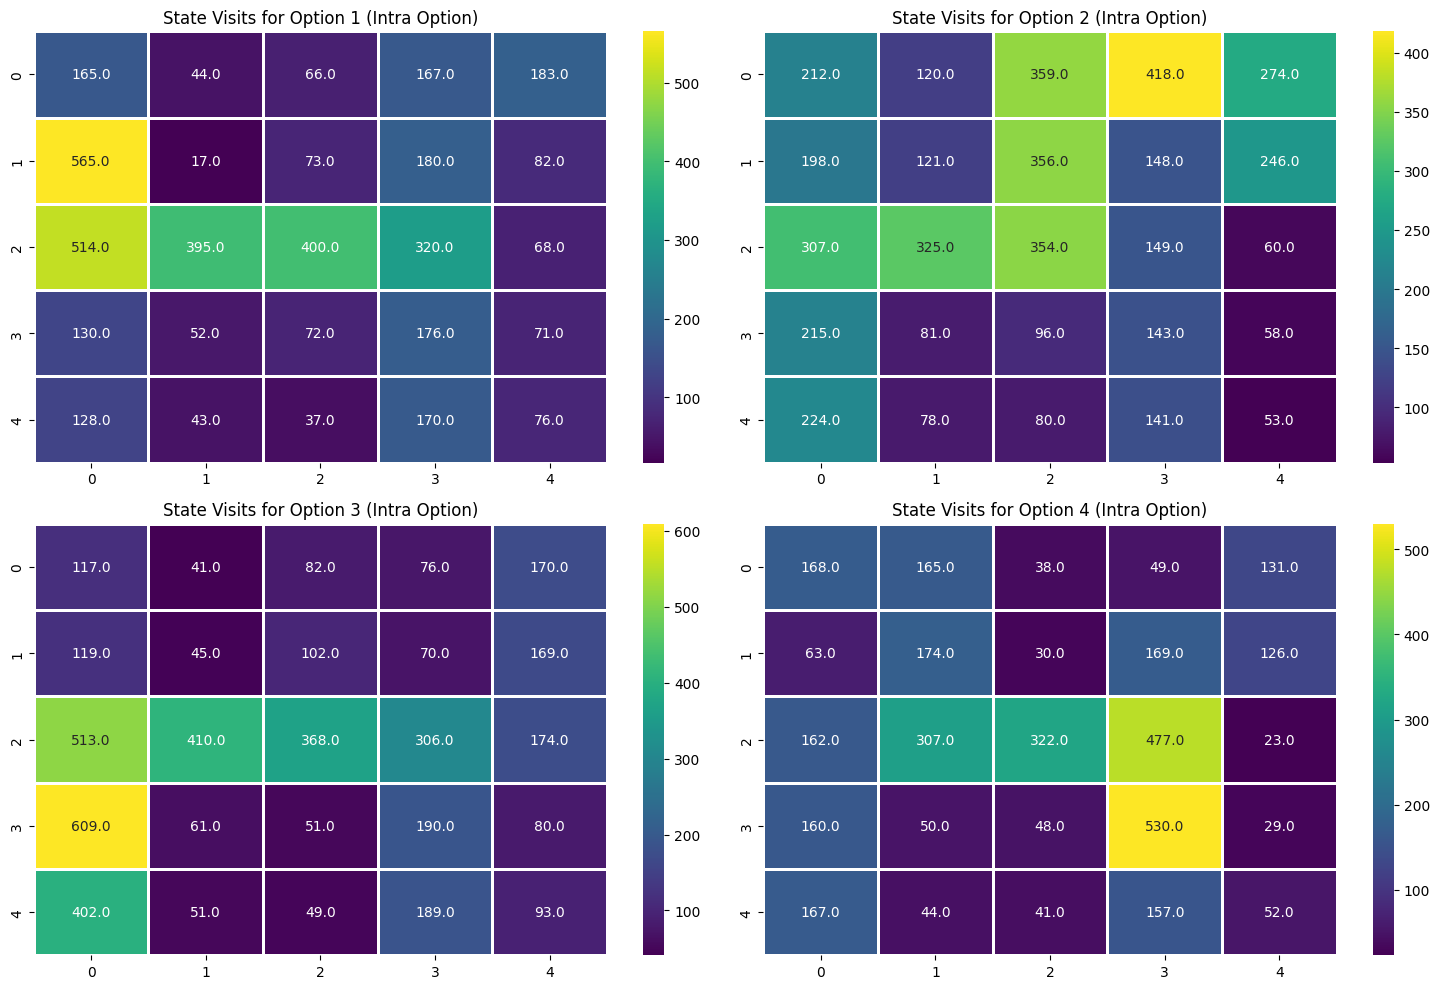

In [206]:
fig, axis = plt.subplots(2,2,figsize=(15,10))
for i in range(2):
    for j in range(2):
        ax = sns.heatmap((state_count[2*i+j].reshape(5,5)), ax=axis[i,j],annot=True,fmt="",linewidths=1,linecolor='white',cmap='viridis')
        axis[i,j].set_title(f"State Visits for Option {i*2+j+1} (Intra Option)")
        c_bar = ax.collections[0].colorbar
plt.tight_layout()
plt.show()

In [207]:
env = gym.make("Taxi-v3", new_step_api=True)
env.reset()

state = env.reset()
done = False
total_reward = 0

x, y, pas, drop = env.decode(state)
print(f"Starting the Taxi from Cell: {x, y}, Passenger Location: {pas}, Drop Location: {drop}\n\n")
while not done:

    _, _, pas, drop = env.decode(state)
    subState = 4*pas+drop
    action = epsilon_greedy(q_values_option, subState, eps_start)
    eps_start = max(eps_start, eps_decay*eps_start)

    option = action
    optdone = False
    prev = state

    while not optdone and not done:

        optact, optdone = Option(env, state, q_values_primitive, option, eps[option])
        next_state, reward, done, _, _ = env.step(optact)
        clear_output(wait=True)
        env.render()

        total_reward+=reward
        x, y, pas, drop = list(env.decode(state))
        x1, y1, pas1, drop1 = list(env.decode(next_state))

        reward_temp = reward
        if optdone:
            reward_temp = 20
        if optact < 4:
            q_values_primitive[option][5*x+y, optact] = (1-alpha)*q_values_primitive[option][5*x+y, optact] + alpha*(reward_temp+gamma*np.max(q_values_primitive[option][5*x1+y1, :])) 

        for i in range(num_options):
            temp_optact, temp_optdone = Option(env, state, q_values_primitive, i, epsilon)

            if temp_optact == optact:
                u = (1-temp_optdone)*q_values_option[Sub(next_state), i] + (temp_optdone)*np.max(q_values_option[Sub(next_state), :])
                q_values_option[Sub(state), i] = (1-alpha)*q_values_option[Sub(state), i] + alpha*(reward+gamma*u)
        state = next_state    

env.close()
print(f"Reward Earned by Intra Option Learning: {total_reward}")

Reward Earned by Intra Option Learning: 14


In [208]:
bottleneckState = {0:[2,0], 1:[2,3], 2:[2,4]}
criticalState = {0:[0,2], 1:[1,2], 2:[4,1], 3:[3,1], 4:[4,2], 5:[3,2]}
middleState = {0:[2,1], 1:[2,2], 2:[2,3]}

In [209]:
# q_values_primitive[0]np.random.choice(q_values_primitive[0][3])
list(q_values_primitive[0][3]).index(np.random.choice(q_values_primitive[0][3]))

0

In [264]:
def NewOption(env, state, q_value, goalNum, epsilon=0.45):

    optdone = False
    x, y, pas, drop = list(env.decode(state))

    if (x == goal[goalNum][0] and y == goal[goalNum][1]):
        optdone = True
        if pas == goalNum:
            optact = 4
        elif drop == goalNum:
            optact = 5
        else:
            optact = np.random.randint(0, 4)

    elif [x, y] in bottleneckState.values():
        if np.random.rand() < epsilon:
            optact = list(q_value[goalNum][5*x+y]).index(np.random.choice(q_value[goalNum][5*x+y], p=[0.4, 0.4, 0.1, 0.1]))
        else:
            optact = np.argmax(q_value[goalNum][5*x+y][:2])
    
    elif [x, y] in criticalState.values():
        # if np.random.rand() < epsilon:
        #     optact = list(q_value[goalNum][5*x+y]).index(np.random.choice(q_value[goalNum][5*x+y], p=[0.5, 0.5, 0.0, 0.0]))
        # else:
        #     optact = np.argmax(q_value[goalNum][5*x+y][:2])
        optact = list(q_value[goalNum][5*x+y]).index(np.random.choice(q_value[goalNum][5*x+y][0:2]))

    elif [x, y] in middleState.values():
        optact = list(q_value[goalNum][5*x+y]).index(np.random.choice(q_value[goalNum][5*x+y][2:4]))

    else:
        optact = epsilon_greedy(q_value[goalNum], 5*x+y, epsilon)

    return [optact, optdone]

In [214]:
num_options = 4
episodes = 1000
q_intra_new_reward = []

gamma = 0.9
alpha = 0.1
epsilon = 0.1
flag = False
repeat = 0

q_values_new_option = np.zeros((20, num_options))
q_values_new_primitive = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_options)}

for _ in tqdm(range(episodes)):

    state = env.reset()
    done = False
    total_reward = 0

    while not done:

        _, _, pas, drop = list(env.decode(state))
        subState = 4*pas + drop
        action = epsilon_greedy(q_values_new_option, subState, eps_start)
        eps_start = max(eps_start, eps_decay*eps_start)

        option = action
        optdone = False
        prev = state

        while not optdone and not done:

            optact, optdone = NewOption(env, state, q_values_new_primitive, option)
            next_state, reward, done, _, _ = env.step(optact)
            total_reward+=reward

            x, y, pas, drop = list(env.decode(state))
            x1, y1, pas1, drop1 = list(env.decode(next_state))

            reward_temp = reward
            if optdone:
                reward_temp = 20
            if optact < 4:
                q_values_new_primitive[option][5*x+y, optact] = (1-alpha)*q_values_new_primitive[option][5*x+y, optact] + alpha*(reward_temp+gamma*np.max(q_values_new_primitive[option][5*x1+y1, :])) 

            for i in range(num_options):
                temp_optact, temp_optdone = NewOption(env, state, q_values_new_primitive, i)

                if temp_optact == optact:
                    u = (1-temp_optdone)*q_values_new_option[Sub(next_state), i] + (temp_optdone)*np.max(q_values_new_option[Sub(next_state), :])
                    q_values_new_option[Sub(state), i] = (1-alpha)*q_values_new_option[Sub(state), i] + alpha*(reward+gamma*u)
            state = next_state
    
    q_intra_new_reward.append(total_reward)

100%|██████████| 1000/1000 [00:05<00:00, 167.89it/s]


-10.747388888888889

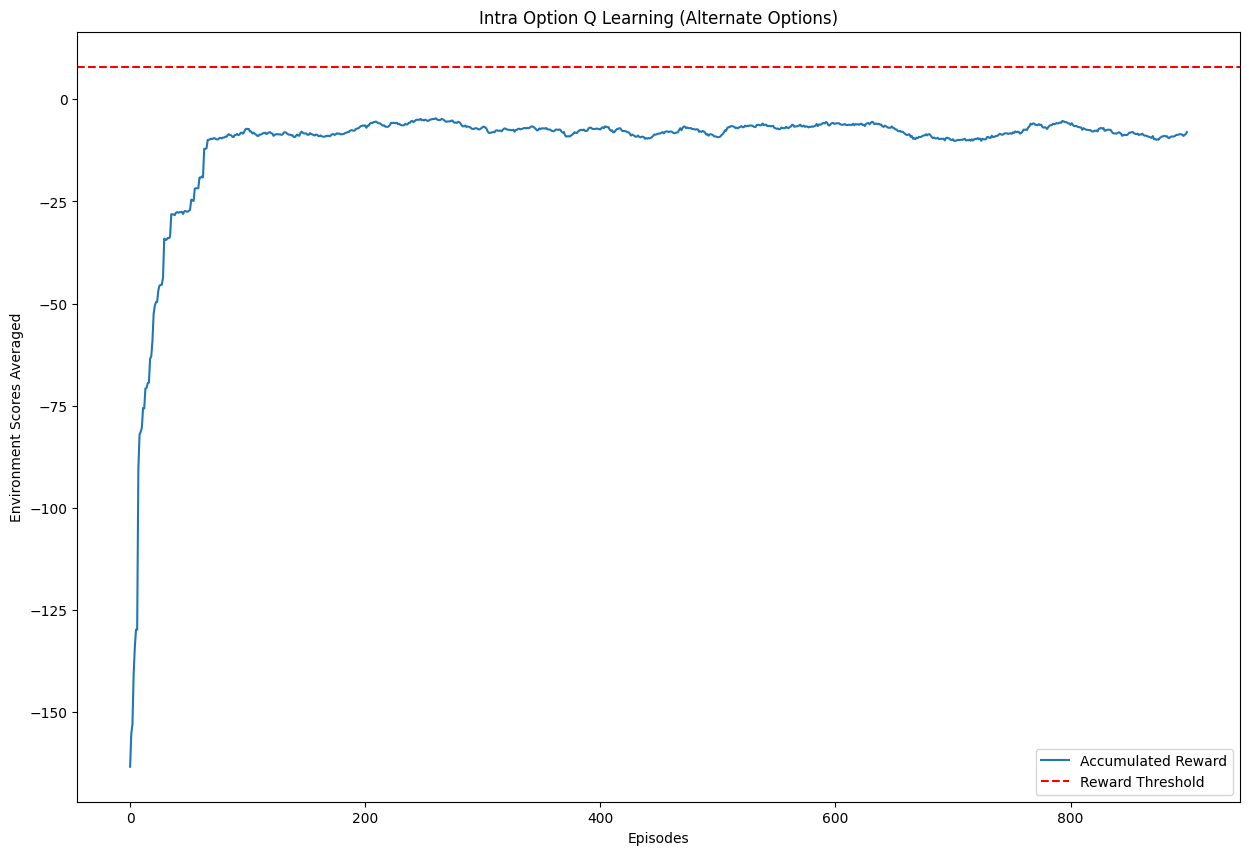

In [216]:
average_new_reward = [np.average(q_intra_new_reward[i:i+100]) for i in range(len(q_intra_new_reward) - 100)]
plt.figure(figsize=(15, 10))
plt.plot(average_new_reward, label='Accumulated Reward')
plt.xlabel('Episodes')
plt.ylabel('Environment Scores Averaged')
plt.title("Intra Option Q Learning (Alternate Options)")
plt.axhline(y=env.spec.reward_threshold, color='red', linestyle='--', label='Reward Threshold')
plt.legend()

np.mean(average_new_reward)

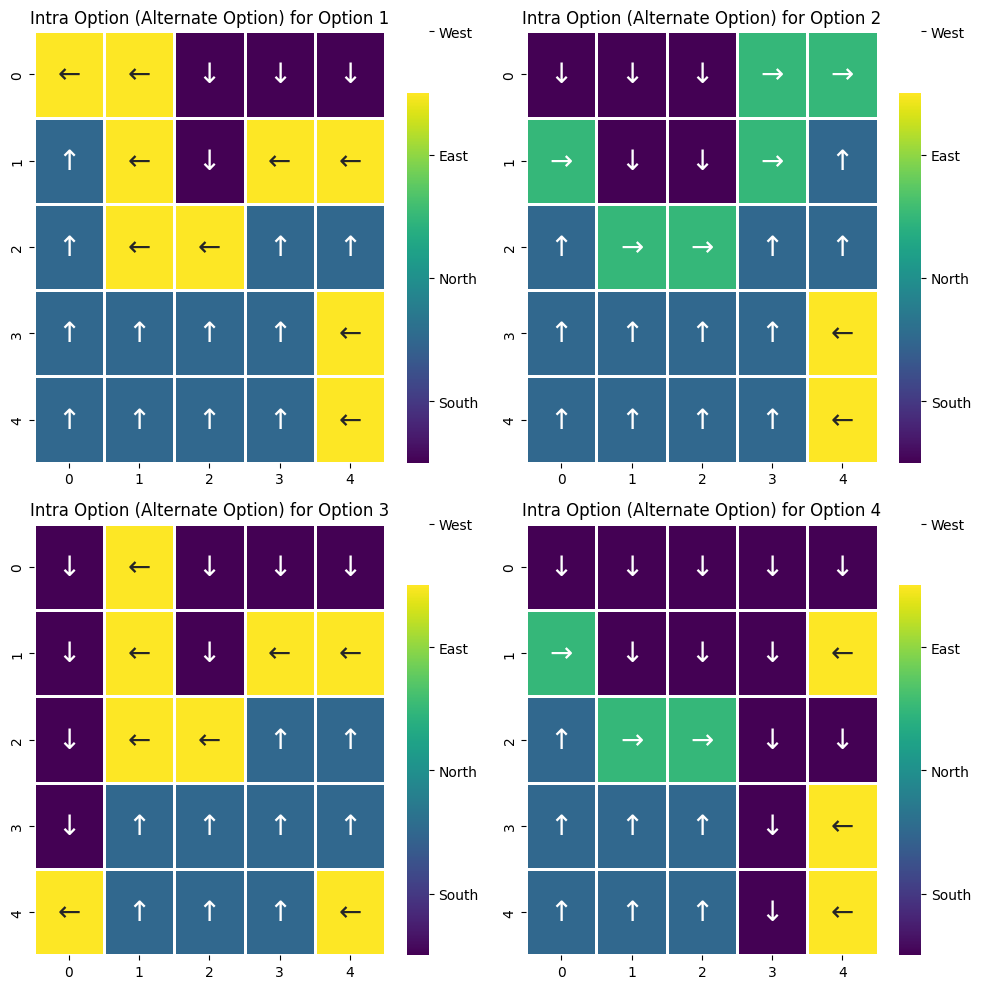

In [217]:
fig, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    for j in range(2):
        labels = {0:'\u2193', 
                  1:'\u2191', 
                  2:'\u2192', 
                  3:'\u2190'}
        annot_text = np.vectorize(labels.get)(np.argmax(q_values_new_primitive[2*i+j], axis=1).reshape(5,5))
        ax = sns.heatmap(np.argmax(q_values_new_primitive[2*i+j], axis=1).reshape(5,5), ax=axis[i,j],annot=annot_text,fmt="",linewidths=1,linecolor='white',cmap='viridis',annot_kws={"size":20})
        axis[i,j].set_title(f"Intra Option (Alternate Option) for Option {i*2+j+1}")
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i + 0.5 for i in range(4)])
        c_bar.set_ticklabels(['South', 'North', 'East', 'West'])

plt.tight_layout()
plt.show()

In [218]:
env = gym.make("Taxi-v3", new_step_api=True)
env.reset()

state = env.reset()
done = False
total_reward = 0


while not done:

    _, _, pas, drop = env.decode(state)
    subState = 4*pas+drop
    action = epsilon_greedy(q_values_new_option, subState, eps_start)
    eps_start = max(eps_start, eps_decay*eps_start)

    option = action
    optdone = False
    prev = state

    while not optdone and not done:

        optact, optdone = NewOption(env, state, q_values_new_primitive, option)
        next_state, reward, done, _, _ = env.step(optact)
        clear_output(wait=True)
        env.render()

        total_reward+=reward
        x, y, pas, drop = list(env.decode(state))
        x1, y1, pas1, drop1 = list(env.decode(next_state))

        reward_temp = reward
        if optdone:
            reward_temp = 20
        if optact < 4:
            q_values_new_primitive[option][5*x+y, optact] = (1-alpha)*q_values_new_primitive[option][5*x+y, optact] + alpha*(reward_temp+gamma*np.max(q_values_new_primitive[option][5*x1+y1, :])) 

        for i in range(num_options):
            temp_optact, temp_optdone = NewOption(env, state, q_values_new_primitive, i)

            if temp_optact == optact:
                u = (1-temp_optdone)*q_values_new_option[Sub(next_state), i] + (temp_optdone)*np.max(q_values_new_option[Sub(next_state), :])
                q_values_new_option[Sub(state), i] = (1-alpha)*q_values_new_option[Sub(state), i] + alpha*(reward+gamma*u)
        state = next_state    

env.close()
print(f"Reward Earned by Intra Option Learning by Alternate Options: {total_reward}")

Reward Earned by Intra Option Learning by Alternate Options: -11


### Comparison Between SMDP and Intra Option Learning

In [219]:
def xy_to_state(x, y):
    return 5*x+y

In [220]:
def get_grid_no_drop(pas, drop, nDrops=4):
    return nDrops*pas+drop

In [221]:
def SMDPOption(Q, state, square_colour, goal, eps=0.1):
    optdone = False
    taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
        state)
    if taxi_row == goal[square_colour][0] and taxi_col == goal[square_colour][1]:
        optdone = True
        if passenger_location_id == square_colour:
            optact = 4
        elif drop_location_id == square_colour:
            optact = 5
        else:
            if square_colour == 0:
                optact = 0
            elif square_colour == 1:
                optact = 0
            elif square_colour == 2:
                optact = 1
            else:
                optact = 1
    else:
        optact = epsilon_greedy(Q[square_colour], xy_to_state(
            taxi_row, taxi_col), epsilon=eps)
    return [optact, optdone]

In [223]:
env.decode(state)

In [265]:
from collections import deque

goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
gamma = 0.9
alpha = 0.1
number_options = 4
nPas = 5  # number of passengger locations
nDrops = 4  # number of drop locations

Qopt = {i: np.zeros((25, 4))
        for i in range(number_options)}

Q_smdp = np.zeros((nPas*nDrops, number_options))
epsilon = [0.1 for i in range(number_options)]
epsilon_min = 0.01
decay_factor = 0.99
episodes = 1000
count = 0
rewards_smdp = []
goal = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
eps_q = 0.2

score_history = deque(maxlen=100)
for i in tqdm(range(episodes)):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)
        subState = get_grid_no_drop(passenger_location_id, drop_location_id)
        action = epsilon_greedy(Q_smdp, subState, epsilon=eps_q)
        eps_q = max(epsilon_min, eps_q*decay_factor)
        reward_bar = 0
        optdone = False
        k = 0
        prev = state
        while not optdone and not done:
            optact, optdone = NewOption(env, state, Qopt, action)
            taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                state)
            next_state, reward, done, _, _ = env.step(optact)
            taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                next_state)
            total_reward += reward
            reward_bar = gamma*reward_bar + reward
            k += 1
            epsilon[action] = max(
                epsilon_min, epsilon[action]*decay_factor)
            reward_surr = reward
            if optact < 4:
                Qopt[action][xy_to_state(taxi_row, taxi_col), optact] = Qopt[action][xy_to_state(taxi_row, taxi_col), optact]+alpha*(
                    reward_surr+gamma*np.max(Qopt[action][xy_to_state(taxi_row_new, taxi_col_new), :])-Qopt[action][xy_to_state(taxi_row, taxi_col), optact])
            state = next_state
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_new = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_prev, taxi_col_prev, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_old = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        # this is where the smdp update is done
        Q_smdp[dropgridno_old, action] += alpha*(reward_bar+(gamma**k)*np.max(
            Q_smdp[dropgridno_new, :])-Q_smdp[dropgridno_old, action])
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)

        if passenger_location_id == drop_location_id:
            count += 1
    rewards_smdp.append(total_reward)
    score_history.append(total_reward)

100%|██████████| 1000/1000 [00:13<00:00, 72.63it/s]


-236.25351111111112

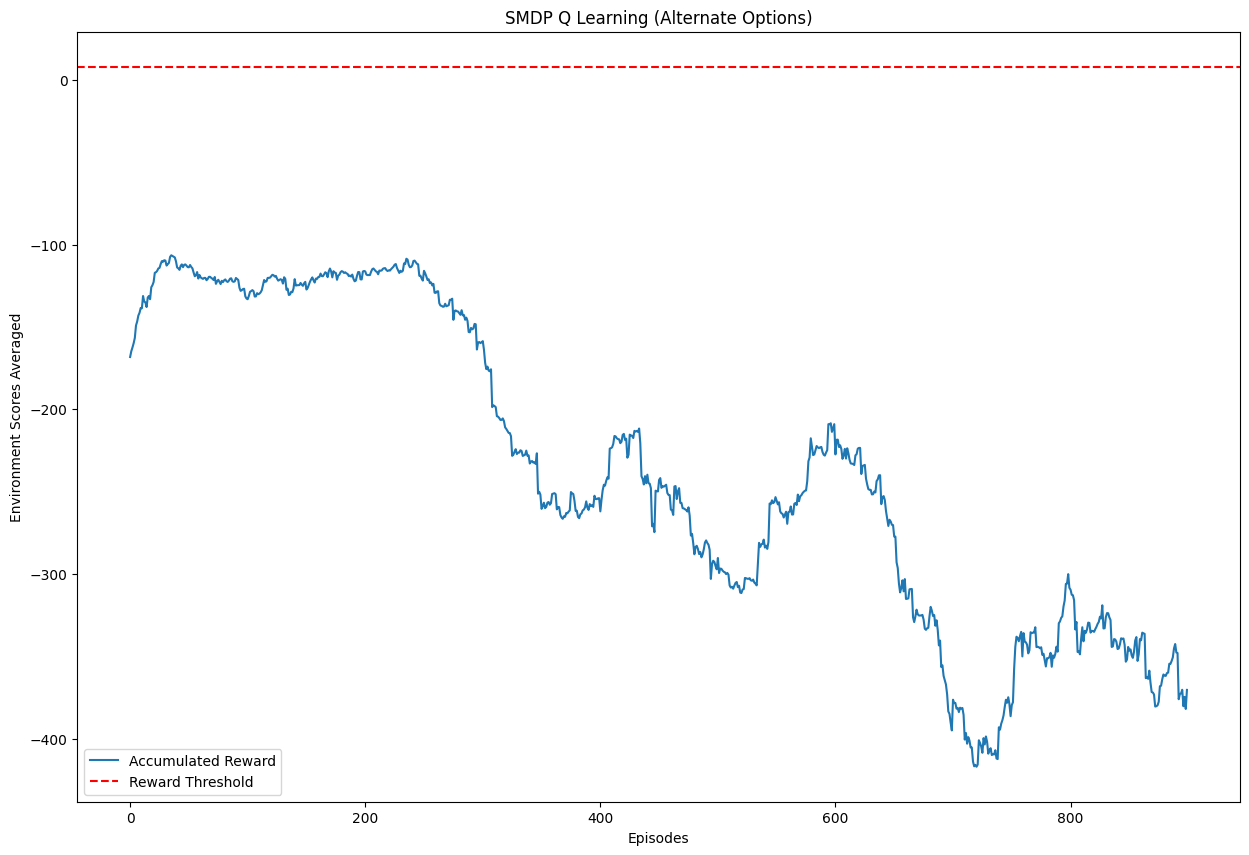

In [266]:
average_reward_smdp = [np.average(rewards_smdp[i:i+100]) for i in range(len(rewards_smdp) - 100)]
plt.figure(figsize=(15, 10))
plt.plot(average_reward_smdp, label='Accumulated Reward')
plt.xlabel('Episodes')
plt.ylabel('Environment Scores Averaged')
plt.title("SMDP Q Learning (Alternate Options)")
plt.axhline(y=env.spec.reward_threshold, color='red', linestyle='--', label='Reward Threshold')
plt.legend()

np.mean(average_reward_smdp)

### Comparison Plot

In [256]:
from collections import deque

goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
gamma = 0.9
alpha = 0.1
number_options = 4
nPas = 5  # number of passengger locations
nDrops = 4  # number of drop locations

Qopt = {i: np.zeros((25, 4))
        for i in range(number_options)}

Q_smdp = np.zeros((nPas*nDrops, number_options))
epsilon = [0.1 for i in range(number_options)]
epsilon_min = 0.01
decay_factor = 0.99
episodes = 1000
count = 0
rewards_smdp = []
goal = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
eps_q = 0.2

score_history = deque(maxlen=100)
for i in tqdm(range(episodes)):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)
        subState = get_grid_no_drop(passenger_location_id, drop_location_id)
        action = epsilon_greedy(Q_smdp, subState, epsilon=eps_q)
        eps_q = max(epsilon_min, eps_q*decay_factor)
        reward_bar = 0
        optdone = False
        k = 0
        prev = state
        while not optdone and not done:
            optact, optdone = SMDPOption(
                Qopt, state, action, goal, epsilon[action])
            taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                state)
            next_state, reward, done, _, _ = env.step(optact)
            taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                next_state)
            total_reward += reward
            reward_bar = gamma*reward_bar + reward
            k += 1
            epsilon[action] = max(
                epsilon_min, epsilon[action]*decay_factor)
            reward_surr = reward
            if optact < 4:
                Qopt[action][xy_to_state(taxi_row, taxi_col), optact] = Qopt[action][xy_to_state(taxi_row, taxi_col), optact]+alpha*(
                    reward_surr+gamma*np.max(Qopt[action][xy_to_state(taxi_row_new, taxi_col_new), :])-Qopt[action][xy_to_state(taxi_row, taxi_col), optact])
            state = next_state
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_new = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_prev, taxi_col_prev, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_old = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        # this is where the smdp update is done
        Q_smdp[dropgridno_old, action] += alpha*(reward_bar+(gamma**k)*np.max(
            Q_smdp[dropgridno_new, :])-Q_smdp[dropgridno_old, action])
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)

        if passenger_location_id == drop_location_id:
            count += 1
    rewards_smdp.append(total_reward)
    score_history.append(total_reward)

100%|██████████| 1000/1000 [00:01<00:00, 660.25it/s]


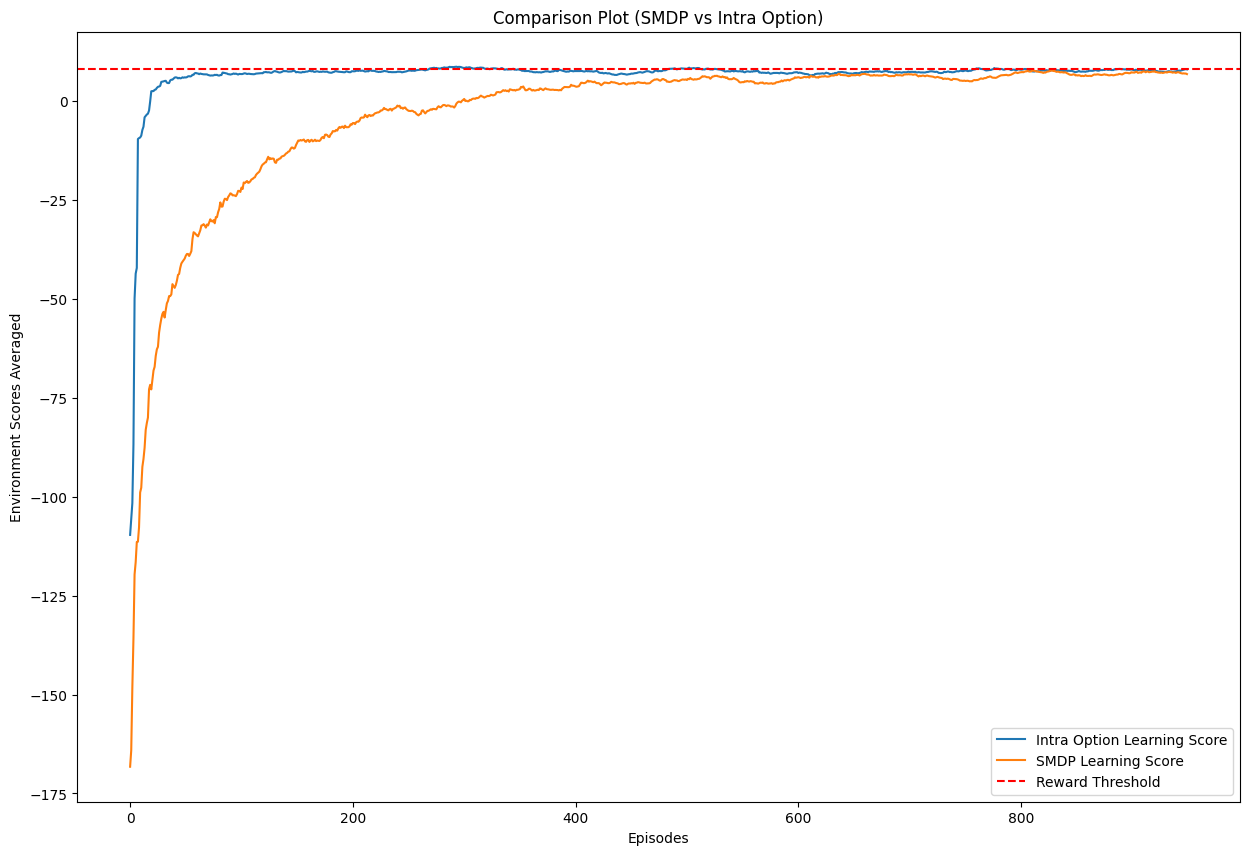

In [258]:
average_intra_reward = [np.average(q_intra_reward[i:i+50]) for i in range(len(q_intra_reward) - 50)]
average_smdp_reward = [np.average(rewards_smdp[i:i+50]) for i in range(len(rewards_smdp) - 50)]
plt.figure(figsize=(15,10))
plt.plot(average_intra_reward, label='Intra Option Learning Score')
plt.plot(average_smdp_reward, label='SMDP Learning Score')
plt.xlabel('Episodes')
plt.ylabel('Environment Scores Averaged')
plt.title("Comparison Plot (SMDP vs Intra Option)")
plt.axhline(y=env.spec.reward_threshold, color="red", linestyle='--', label="Reward Threshold")
plt.legend()
